In [5]:
#Libraries for creating and processing data
import numpy as np
import pandas as pd

#Libraries for processing date of the purchases 
import time, warnings #import waring to ignore the unwanted warnings 
import datetime as dt

#Libraries for visualization 
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.cluster import silhouette_visualizer

#libraries for creating model and clustering
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

#ignore the warnings
warnings.filterwarnings("ignore")

In [6]:
#Import The data
data = pd.read_csv('data.csv', encoding = "ISO-8859-1")

In [7]:
#Check the imported data
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [8]:
#Select the data for United Kingdom only
data_uk = data[data["Country"] == 'United Kingdom']

#Check the number of entries in the data
data_uk.shape

(495478, 8)

In [9]:
#Remove the entries which do not have Customer ID
data_uk.dropna(subset = ['CustomerID'], how = 'all', inplace = True)

#Check the number of entries 
data_uk.shape

(361878, 8)

# Summary of the Data

In [10]:
#Print different columns of the data
print("Number of transactions: ", data_uk['InvoiceNo'].nunique())
print("Number of products bought: ",data_uk['StockCode'].nunique())
print("Number of customers:", data_uk['CustomerID'].nunique())


#To Check that there is transaction which is not associated with customer Id
customer_nan = round(data_uk['CustomerID'].isnull().sum(), 2)# here 2 is the number of digits i.e. output will be = 0.0
print("Number of entries without customer ID", customer_nan)

Number of transactions:  19857
Number of products bought:  3661
Number of customers: 3950
Number of entries without customer ID 0


# Calculate the Recency

In [11]:
#Find the dtae of last transaction 
data_uk['InvoiceDate'].max()

'9/9/2011 9:52'

In [12]:
#Store the last date found
last_date = dt.date(2011, 12, 9)

#Check the date
print(last_date)

2011-12-09


In [13]:
#Make the column of date of each transaction
data_uk['Date'] = pd.DatetimeIndex(data_uk['InvoiceDate']).date

#Check the data is processed or not
data_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,2010-12-01


In [14]:
#Create a data frame for storing the recency
recency = data_uk.groupby(by = 'CustomerID', as_index = False)['Date'].max()
recency.columns = ['CustomerID', 'LastDate']

#check the data frame
recency.head()

,CustomerID,LastDate
0,12346.0,2011-01-18
1,12747.0,2011-12-07
2,12748.0,2011-12-09
3,12749.0,2011-12-06
4,12820.0,2011-12-06


In [15]:
#Subtract the last date of each transaction with last_date we found
recency['Recency'] = recency['LastDate'].apply(lambda x:(last_date - x).days)

#Remove the Last Date column
recency.drop('LastDate', inplace = True, axis = 1)

#Check the data
recency.head()

,CustomerID,Recency
0,12346.0,325
1,12747.0,2
2,12748.0,0
3,12749.0,3
4,12820.0,3


# Calculate Monetary

In [16]:
#Find the total amout purchased by each customer
data_uk['Total'] = data_uk['Quantity']*data_uk['UnitPrice']

In [17]:
#Create a new data frame for monetary value
monetary = data_uk.groupby(by = 'CustomerID', as_index = False).agg({'Total': 'sum'})
monetary.columns = ['CustomerID', 'Monetary']

#Check the data frame
monetary.head()

,CustomerID,Monetary
0,12346.0,0.00
1,12747.0,4196.01
2,12748.0,29072.10
3,12749.0,3868.20
4,12820.0,942.34


# Calculate Frequency

In [18]:
#First create a temp data
data_uk_temp = data_uk
#Remove the duplicates values
#Just to ensure that the transaction which took place on same day, must be deleted
data_uk_temp.drop_duplicates(subset=['InvoiceNo', 'CustomerID'], keep="first", inplace=True)

#create data frame for storing frequency
frequency = data_uk_temp.groupby(by=['CustomerID'], as_index=False)['InvoiceNo'].count()
frequency.columns = ['CustomerID','Frequency']
frequency.head()

,CustomerID,Frequency
0,12346.0,2
1,12747.0,11
2,12748.0,224
3,12749.0,8
4,12820.0,4


# Create RFM Table


In [19]:
#Merge all the three data set
temp_df = recency.merge(frequency, on = 'CustomerID')

rfm_df = temp_df.merge(monetary, on = 'CustomerID')
rfm_df.set_index('CustomerID',inplace=True)
rfm_df.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,2,0.00
12747.0,2,11,4196.01
12748.0,0,224,29072.10
12749.0,3,8,3868.20
12820.0,3,4,942.34


# Visualize the RFM Table

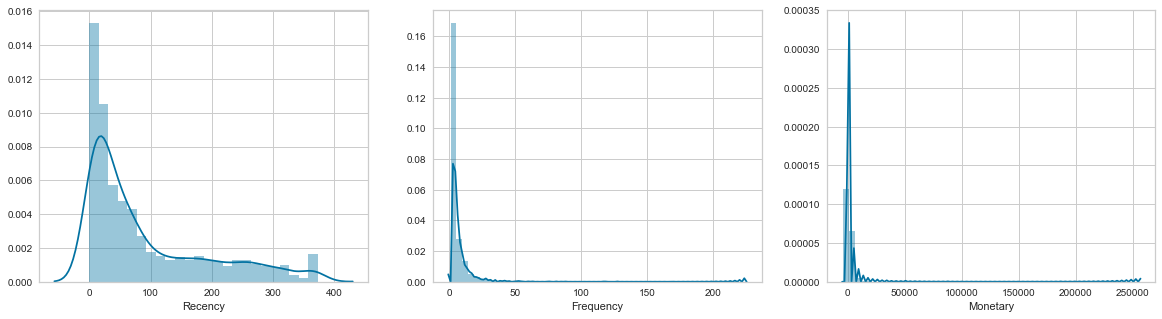

In [20]:
fig, axes = plt.subplots(1, 3, figsize = (20, 5))
for i, feature in enumerate(list(rfm_df.columns)):
    sns.distplot(rfm_df[feature], ax = axes[i])

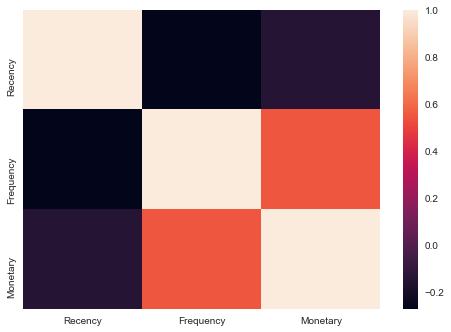

In [21]:
#Create a heat map 
sns.heatmap(rfm_df.iloc[:, 0:3].corr()) # all rows , with column 0 to 3

# Scale the data

In [22]:
scaler = MinMaxScaler()
rfm_normalized = pd.DataFrame(scaler.fit_transform(rfm_df))
rfm_normalized.columns = ['n_Recency', 'n_Frequency', 'n_Monetary']
rfm_normalized.describe()

,n_Recency,n_Frequency,n_Monetary
count,3950.000000,3950.000000,3950.000000
mean,0.244834,0.018059,0.023017
std,0.268731,0.039091,0.025117
min,0.000000,0.000000,0.000000
25%,0.042895,0.000000,0.017528
50%,0.134048,0.008969,0.018850
75%,0.383378,0.017937,0.022282
max,1.000000,1.000000,1.000000


# Elbow Method to Find value for K

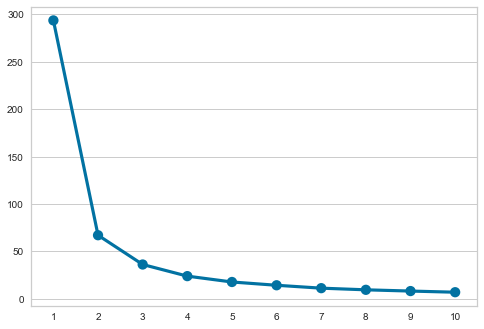

In [23]:
# SSE = Sum of squared errors
SSE = []
for k in range(0, 10):
    kmeans = KMeans(n_clusters = k+1, random_state = 1231).fit(rfm_normalized)
    SSE.append(kmeans.inertia_)
    
sns.pointplot(x = list(range(1, 11)), y = SSE)
plt.show()

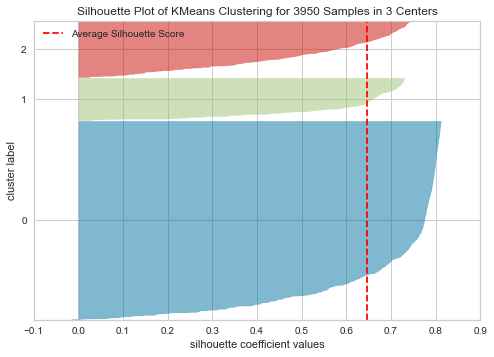

In [24]:
s_visual = silhouette_visualizer(KMeans(3, random_state = 42),rfm_normalized, colors = 'yellowbrick')

# KMeans Clustering

In [25]:
#Create the model
model = KMeans(n_clusters = 3, random_state = 1231).fit(rfm_normalized)

#define centers
centers = model.cluster_centers_

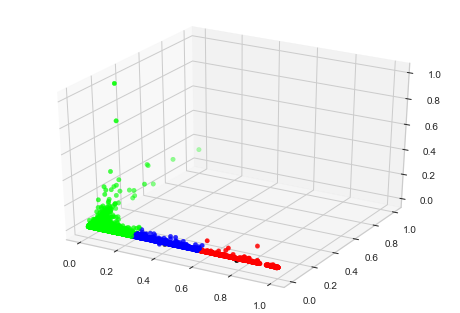

In [26]:
#3d model of the centers and the kmodel
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(rfm_normalized['n_Recency'], rfm_normalized['n_Frequency'], rfm_normalized['n_Monetary'], cmap = 'brg', c = model.predict(rfm_normalized))
ax.scatter(centers[:, 0], centers[:, 1], c = 'black');

In [27]:
rfm = pd.DataFrame(scaler.inverse_transform(rfm_normalized))
rfm.columns = rfm_df.columns
rfm['CustomerID'] = rfm_df.index
rfm['Cluster'] = model.labels_

In [28]:
rfm

,Recency,Frequency,Monetary,CustomerID,Cluster
0,325.0,2.0,0.00,12346.0,1
1,2.0,11.0,4196.01,12747.0,2
2,0.0,224.0,29072.10,12748.0,2
3,3.0,8.0,3868.20,12749.0,2
4,3.0,4.0,942.34,12820.0,2
...,...,...,...,...,...
3945,277.0,1.0,180.60,18280.0,1
3946,180.0,1.0,80.82,18281.0,0
3947,7.0,3.0,176.60,18282.0,2
3948,3.0,16.0,2094.88,18283.0,2


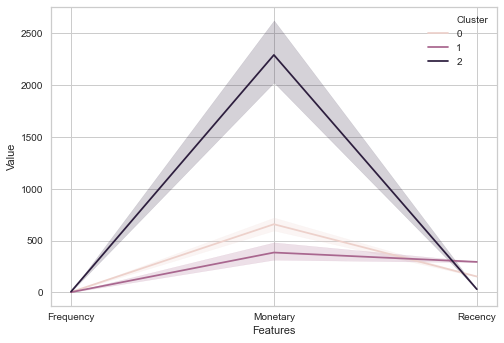

In [29]:
#Visulize the data 
melted_rfm_normalized = pd.melt(rfm.reset_index(), 
                               id_vars = ['CustomerID', "Cluster"],
                               value_vars = ['Recency', 'Frequency', 'Monetary'],
                               var_name = 'Features',
                               value_name = 'Value')
sns.lineplot('Features', 'Value', hue = 'Cluster', data = melted_rfm_normalized)
plt.legend()

# Conclusion

In [30]:
# Group the data and create min. max and mean column of each RFM value
rfm.groupby('Cluster').agg({
    'Recency':['mean', 'min', 'max'],
    'Frequency':['mean', 'min', 'max'],
    'Monetary':['mean', 'min','max', 'count']})

Recency               Frequency                 Monetary           \
               mean    min    max      mean  min    max         mean      min   
Cluster                                                                         
0        153.328378   92.0  222.0  2.579730  1.0   14.0   657.584704 -4287.63   
1        294.221631  225.0  373.0  1.569149  1.0   35.0   384.475567 -1192.20   
2         30.733938    0.0   92.0  6.448602  1.0  224.0  2291.918554 -1165.30   

                          
               max count  
Cluster                   
0         10217.48   740  
1         21535.90   564  
2        256438.49  2646